In [1]:
pip install gradio imutils scikit-image scikit-learn opencv-python matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 29.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 98.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# HOG implementation

In [ ]:
# Global Gradient
def global_gradient(img):
    gx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(gx**2 + gy**2)
    angle = (np.arctan2(gy, gx) * (180 / np.pi)) % 360
    return magnitude, angle

# ------------------------------
# Get Closest Bin (Vectorized)
def get_bins(angle):
    idx = (angle // angle_unit).astype(int)
    mod = angle % angle_unit
    return idx, (idx + 1) % bin_size, mod

# ------------------------------
# Cell Gradient (Vectorized)
def cell_gradient(cell_magnitude, cell_angle):
    orientation_histogram = np.zeros(bin_size)
    idx, idx_next, mod = get_bins(cell_angle)

    for b in range(bin_size):
        mask = (idx == b)
        orientation_histogram[b] += np.sum(cell_magnitude[mask] * (1 - mod[mask] / angle_unit))

        mask_next = (idx_next == b)
        orientation_histogram[b] += np.sum(cell_magnitude[mask_next] * (mod[mask_next] / angle_unit))

    return orientation_histogram
    # HOG Feature Extraction
def extract(img):
    height, width = img.shape
    gradient_magnitude, gradient_angle = global_gradient(img)
    
    cell_gradient_vector = np.zeros((
        height // cell_size,
        width // cell_size,
        bin_size
    ))

    for i in range(cell_gradient_vector.shape[0]):
        for j in range(cell_gradient_vector.shape[1]):
            cell_magnitude = gradient_magnitude[
                i * cell_size:(i + 1) * cell_size,
                j * cell_size:(j + 1) * cell_size
            ]
            cell_angle = gradient_angle[
                i * cell_size:(i + 1) * cell_size,
                j * cell_size:(j + 1) * cell_size
            ]
            cell_gradient_vector[i, j] = cell_gradient(cell_magnitude, cell_angle)

    hog_vector = []
    for i in range(cell_gradient_vector.shape[0] - 1):
        for j in range(cell_gradient_vector.shape[1] - 1):
            block_vector = np.hstack((
                cell_gradient_vector[i, j],
                cell_gradient_vector[i, j + 1],
                cell_gradient_vector[i + 1, j],
                cell_gradient_vector[i + 1, j + 1]
            ))
            norm = np.linalg.norm(block_vector)
            if norm != 0:
                block_vector /= norm
            hog_vector.append(block_vector)
    
    hog_vector = np.array(hog_vector)
    return hog_vector, cell_gradient_vector

# ------------------------------
# Render HOG Image
def render_gradient(img_shape, cell_gradient_vector):
    hog_image = np.zeros(img_shape, dtype=np.uint8)
    max_mag = np.max(cell_gradient_vector)
    if max_mag == 0:
        max_mag = 1

    for x in range(cell_gradient_vector.shape[0]):
        for y in range(cell_gradient_vector.shape[1]):
            cell_grad = cell_gradient_vector[x, y] / max_mag
            angle = 0
            for magnitude in cell_grad:
                angle_radian = math.radians(angle)
                center = (y * cell_size + cell_size // 2, x * cell_size + cell_size // 2)
                dx = int(magnitude * (cell_size // 2) * math.cos(angle_radian))
                dy = int(magnitude * (cell_size // 2) * math.sin(angle_radian))
                pt1 = (center[0] - dx, center[1] - dy)
                pt2 = (center[0] + dx, center[1] + dy)
                cv2.line(hog_image, pt1, pt2, 255, 1)
                angle += angle_unit
    return hog_image
# Example Usage
img_path = '/kaggle/input/uc-merced-land-use-dataset/UCMerced_LandUse/Images/airplane/airplane01.tif'
img = preprocess_image(img_path)

hog_vector, cell_grad = extract(img)
hog_image = render_gradient(img.shape, cell_grad)

# Plot
plt.figure(figsize=(15, 15))
plt.title('Original Image')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 15))
plt.title('HOG Visualization')
plt.imshow(hog_image, cmap='gray')
plt.axis('off')
plt.show()

# HOG-SVM OBJECT DETECTION 

Loading training data from UC Merced dataset...
Training SVM classifier on real HOG features...
Training Accuracy: 100.00%
Testing Accuracy: 77.50%
Number of HOG descriptors: 8100


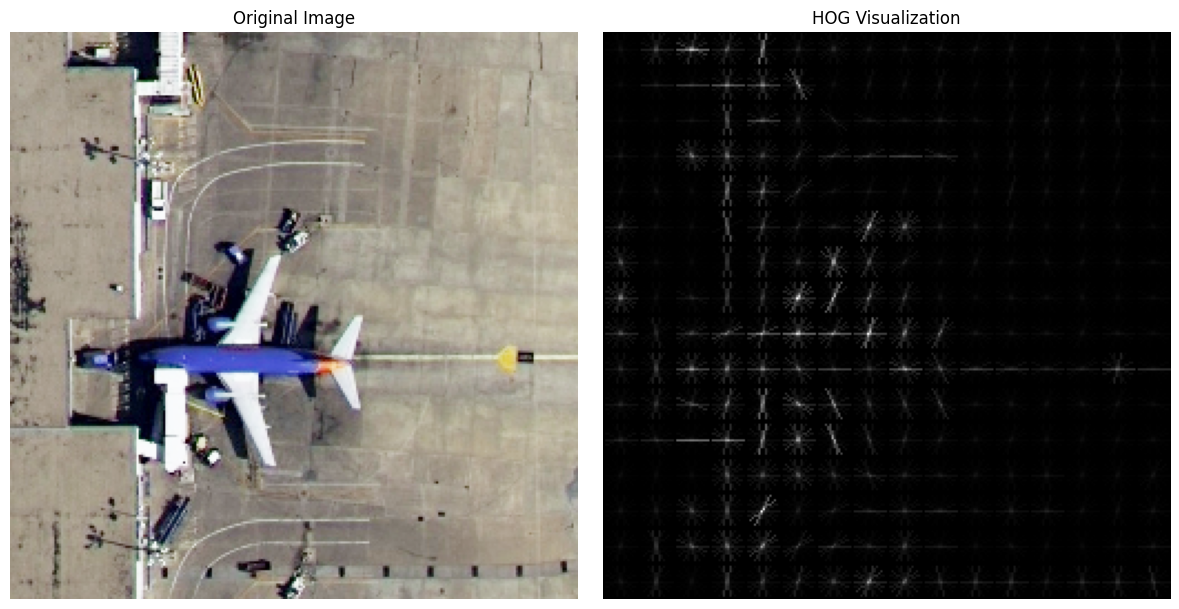

Running sliding window detection...
Raw detections: 1
Final detections after NMS: 1


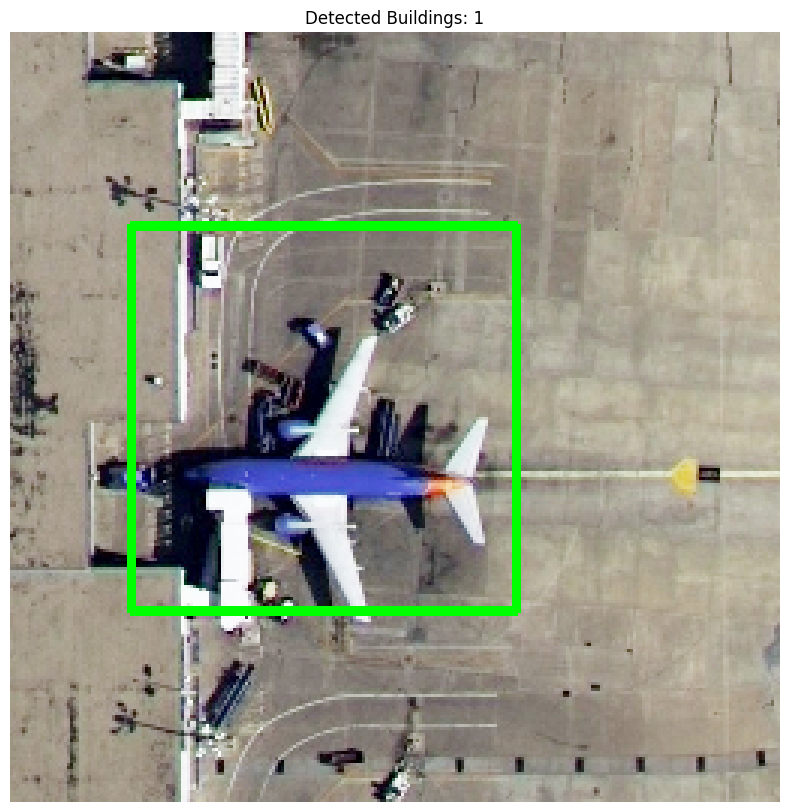

In [2]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from imutils.object_detection import non_max_suppression

class SatelliteHOGDetector:
    def __init__(self, cell_size=16, bin_size=9, block_size=2):
        self.cell_size = cell_size
        self.bin_size = bin_size
        self.block_size = block_size
        self.classifier = None

    def compute_hog(self, img, visualize=False):
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        if visualize:
            features, hog_image = hog(
                img,
                orientations=self.bin_size,
                pixels_per_cell=(self.cell_size, self.cell_size),
                cells_per_block=(self.block_size, self.block_size),
                block_norm='L2-Hys',
                visualize=True,
                transform_sqrt=True,
                feature_vector=True
            )
            hog_image = exposure.rescale_intensity(hog_image, in_range=(0, 10))
            return features, hog_image
        else:
            features = hog(
                img,
                orientations=self.bin_size,
                pixels_per_cell=(self.cell_size, self.cell_size),
                cells_per_block=(self.block_size, self.block_size),
                block_norm='L2-Hys',
                visualize=False,
                transform_sqrt=True,
                feature_vector=True
            )
            return features
    def train(self, X, y):
        self.classifier = SVC(kernel='linear', probability=True)
        self.classifier.fit(X, y)

    def detect_objects(self, img, window_size=(256, 256), stride=32, threshold=0.7):
        if self.classifier is None:
            raise ValueError("Classifier not trained!")

        detections = []
        img_height, img_width = img.shape[:2]

        for y in range(0, img_height - window_size[1], stride):
            for x in range(0, img_width - window_size[0], stride):
                window = img[y:y+window_size[1], x:x+window_size[0]]
                if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
                    continue
                features = self.compute_hog(window)
                proba = self.classifier.predict_proba([features])[0]

                if np.max(proba) > threshold:
                    detections.append((x, y, x+window_size[0], y+window_size[1], np.max(proba)))

        return detections


def load_ucmerced_data(dataset_dir, target_class="airplane", background_class="golfcourse", size=(128, 128), max_per_class=100):
    X = []
    y = []

    for class_name, label in [(target_class, 1), (background_class, 0)]:
        class_dir = os.path.join(dataset_dir, class_name)
        count = 0
        for file in os.listdir(class_dir):
            if file.endswith(".tif") or file.endswith(".jpg"):
                img = cv2.imread(os.path.join(class_dir, file))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, size)
                hog_feat = SatelliteHOGDetector().compute_hog(img)
                X.append(hog_feat)
                y.append(label)
                count += 1
                if count >= max_per_class:
                    break
    return np.array(X), np.array(y)


def plot_hog_comparison(original_img, hog_image):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(original_img, cmap='gray')
    ax1.set_title('Original Image')
    ax1.axis('off')
    ax2.imshow(hog_image, cmap='gray')
    ax2.set_title('HOG Visualization')
    ax2.axis('off')
    plt.tight_layout()
    plt.show()

def main():
    # 1. Load real training data
    dataset_dir = "/kaggle/input/uc-merced-land-use-dataset/UCMerced_LandUse/Images"
    print("Loading training data from UC Merced dataset...")
    X, y = load_ucmerced_data(dataset_dir)

    # 2. Train the classifier
    print("Training SVM classifier on real HOG features...")
    detector = SatelliteHOGDetector()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    detector.train(X_train, y_train)
    print(f"Training Accuracy: {detector.classifier.score(X_train, y_train)*100:.2f}%")
    print(f"Testing Accuracy: {detector.classifier.score(X_test, y_test)*100:.2f}%")

    # 3. Load test image and detect
    test_img_path = "/kaggle/input/uc-merced-land-use-dataset/UCMerced_LandUse/Images/airplane/airplane28.tif"  # Replace with a test image
    img = cv2.imread(test_img_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at {test_img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Optional: visualize HOG
    features, hog_img = detector.compute_hog(img, visualize=True)
    print(f"Number of HOG descriptors: {len(features)}")
    plot_hog_comparison(img, hog_img)

    print("Running sliding window detection...")
    detections = detector.detect_objects(img, window_size=(128, 128), stride=8, threshold=0.99)
    print(f"Raw detections: {len(detections)}")

    if detections:
        boxes = np.array([[x1, y1, x2, y2] for (x1, y1, x2, y2, _) in detections])
        scores = np.array([score for (_, _, _, _, score) in detections])
        pick = non_max_suppression(boxes, scores, overlapThresh=0.3)
        print(f"Final detections after NMS: {len(pick)}")
    else:
        pick = []

    # 4. Visualize results
    result_img = img.copy()
    for (x1, y1, x2, y2) in pick:
        cv2.rectangle(result_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(result_img)
    plt.title(f"Detected Buildings: {len(pick)}")
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()

# GUI

In [3]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from imutils.object_detection import non_max_suppression
import gradio as gr
from PIL import Image

class SatelliteHOGDetector:
    def __init__(self, cell_size=16, bin_size=9, block_size=2):
        self.cell_size = cell_size
        self.bin_size = bin_size
        self.block_size = block_size
        self.classifier = None

    def compute_hog(self, img, visualize=False):
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        if visualize:
            features, hog_image = hog(
                img,
                orientations=self.bin_size,
                pixels_per_cell=(self.cell_size, self.cell_size),
                cells_per_block=(self.block_size, self.block_size),
                block_norm='L2-Hys',
                visualize=True,
                transform_sqrt=True,
                feature_vector=True
            )
            hog_image = exposure.rescale_intensity(hog_image, in_range=(0, 10))
            return features, hog_image
        else:
            features = hog(
                img,
                orientations=self.bin_size,
                pixels_per_cell=(self.cell_size, self.cell_size),
                cells_per_block=(self.block_size, self.block_size),
                block_norm='L2-Hys',
                visualize=False,
                transform_sqrt=True,
                feature_vector=True
            )
            return features

    def train(self, X, y):
        self.classifier = SVC(kernel='linear', probability=True)
        self.classifier.fit(X, y)

    def detect_objects(self, img, window_size=(256, 256), stride=32, threshold=0.7):
        if self.classifier is None:
            raise ValueError("Classifier not trained!")

        detections = []
        img_height, img_width = img.shape[:2]

        for y in range(0, img_height - window_size[1], stride):
            for x in range(0, img_width - window_size[0], stride):
                window = img[y:y+window_size[1], x:x+window_size[0]]
                if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
                    continue
                features = self.compute_hog(window)
                proba = self.classifier.predict_proba([features])[0]

                if np.max(proba) > threshold:
                    detections.append((x, y, x+window_size[0], y+window_size[1], np.max(proba)))

        return detections


def load_ucmerced_data(dataset_dir, target_class="airplane", background_class="golfcourse", size=(128, 128), max_per_class=100):
    X = []
    y = []

    for class_name, label in [(target_class, 1), (background_class, 0)]:
        class_dir = os.path.join(dataset_dir, class_name)
        count = 0
        for file in os.listdir(class_dir):
            if file.endswith(".tif") or file.endswith(".jpg"):
                img = cv2.imread(os.path.join(class_dir, file))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, size)
                hog_feat = SatelliteHOGDetector().compute_hog(img)
                X.append(hog_feat)
                y.append(label)
                count += 1
                if count >= max_per_class:
                    break
    return np.array(X), np.array(y)


# ----------------- GRADIO UI SECTION -------------------

# 1. Prepare and train the detector once
dataset_dir = "/kaggle/input/uc-merced-land-use-dataset/UCMerced_LandUse/Images"  # adjust if needed
detector = SatelliteHOGDetector()
X, y = load_ucmerced_data(dataset_dir)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
detector.train(X_train, y_train)

# 2. Gradio function to show HOG features
def show_hog(image):
    img_np = np.array(image)
    _, hog_img = detector.compute_hog(img_np, visualize=True)
    return Image.fromarray((hog_img * 255).astype(np.uint8))

# 3. Gradio function to detect objects
def detect(image):
    img_np = np.array(image)
    detections = detector.detect_objects(img_np, window_size=(128, 128), stride=8, threshold=0.99)

    if detections:
        boxes = np.array([[x1, y1, x2, y2] for (x1, y1, x2, y2, _) in detections])
        scores = np.array([score for (_, _, _, _, score) in detections])
        pick = non_max_suppression(boxes, scores, overlapThresh=0.3)
    else:
        pick = []

    result_img = img_np.copy()
    for (x1, y1, x2, y2) in pick:
        cv2.rectangle(result_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    return Image.fromarray(result_img)

# 4. Launch Gradio
interface = gr.Interface(
    fn=detect,
    inputs=gr.Image(type="pil"),
    outputs=gr.Image(type="pil"),
    title="Satellite Object Detection using HOG + SVM",
    description="Upload an image to visualize detected objects. Trained on UC Merced dataset."
)

hog_interface = gr.Interface(
    fn=show_hog,
    inputs=gr.Image(type="pil"),
    outputs=gr.Image(type="pil"),
    title="HOG Feature Visualizer",
    description="Upload an image to view its HOG representation."
)

# Combine into tabs
gr.TabbedInterface([interface, hog_interface], ["Detection", "HOG Visualization"]).launch()


* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://6654f9005acbeb6063.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [4]:
example_img = X_train[0]
print("Number of features in one training image:", len(example_img))


Number of features in one training image: 1764


In [5]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = detector.classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["golfcourse", "airplane"]))


Confusion Matrix:
 [[16  3]
 [ 6 15]]

Classification Report:
               precision    recall  f1-score   support

  golfcourse       0.73      0.84      0.78        19
    airplane       0.83      0.71      0.77        21

    accuracy                           0.78        40
   macro avg       0.78      0.78      0.77        40
weighted avg       0.78      0.78      0.77        40



# hog visulaization of different images 

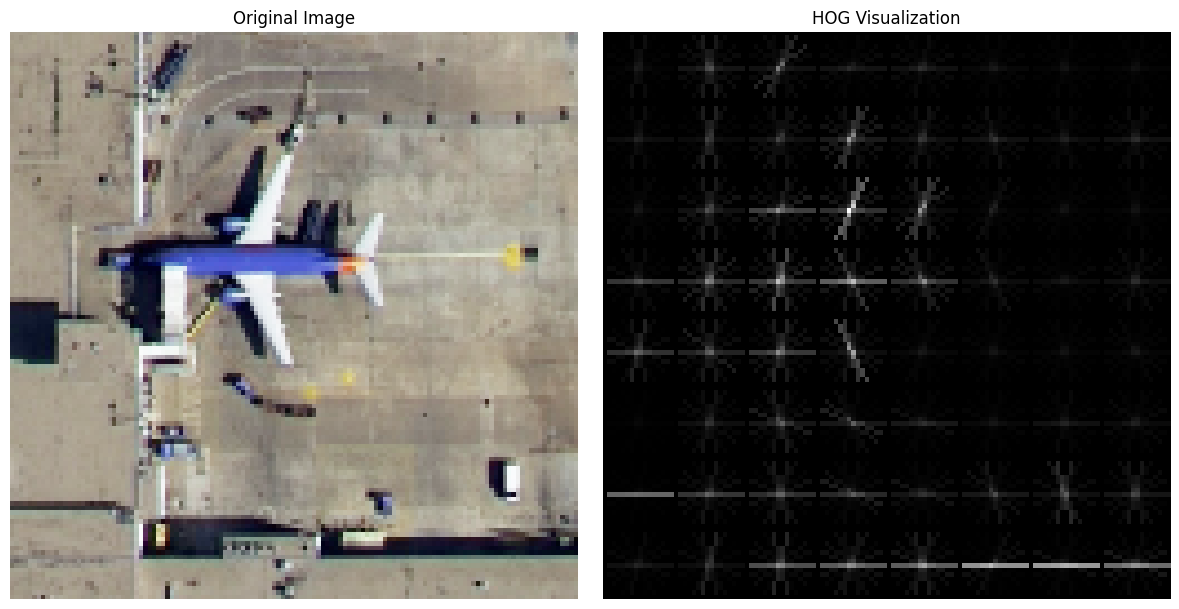

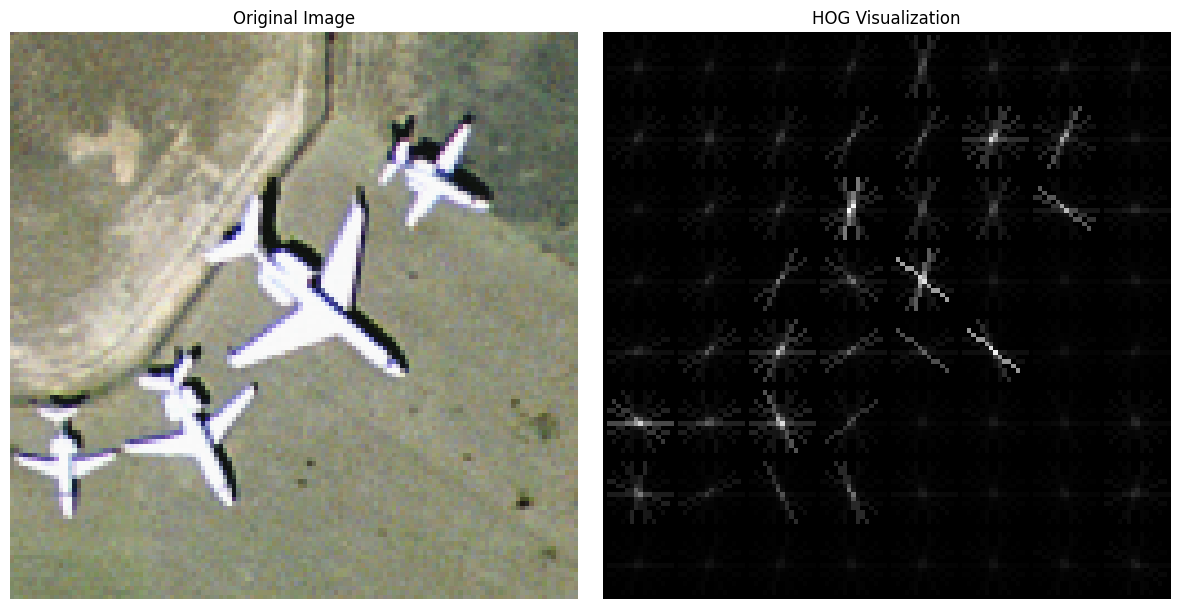

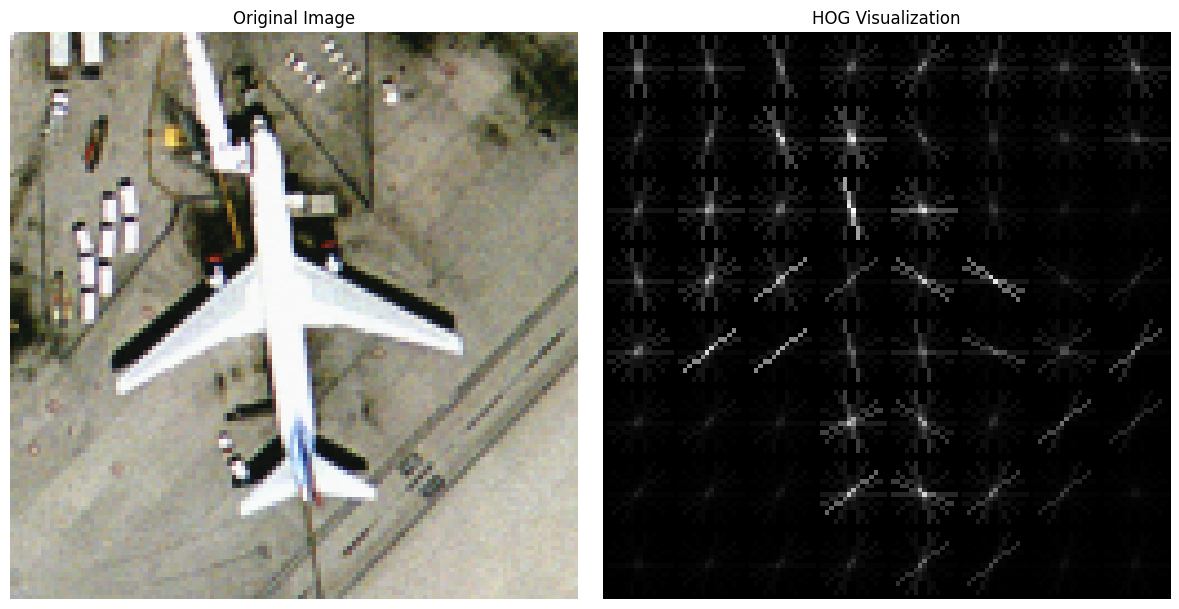

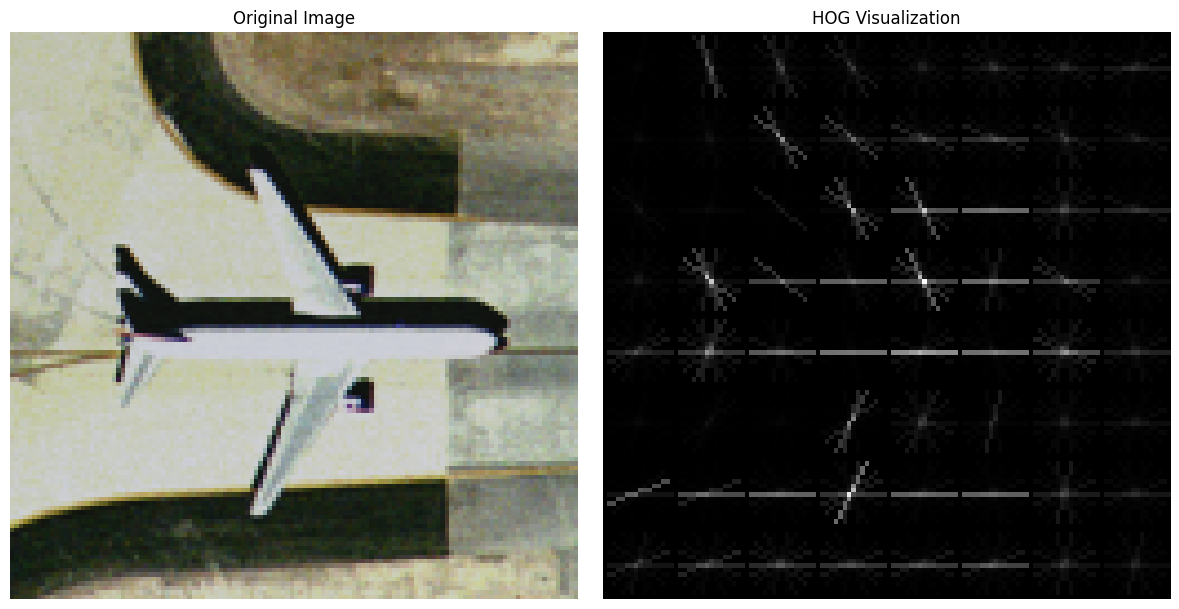

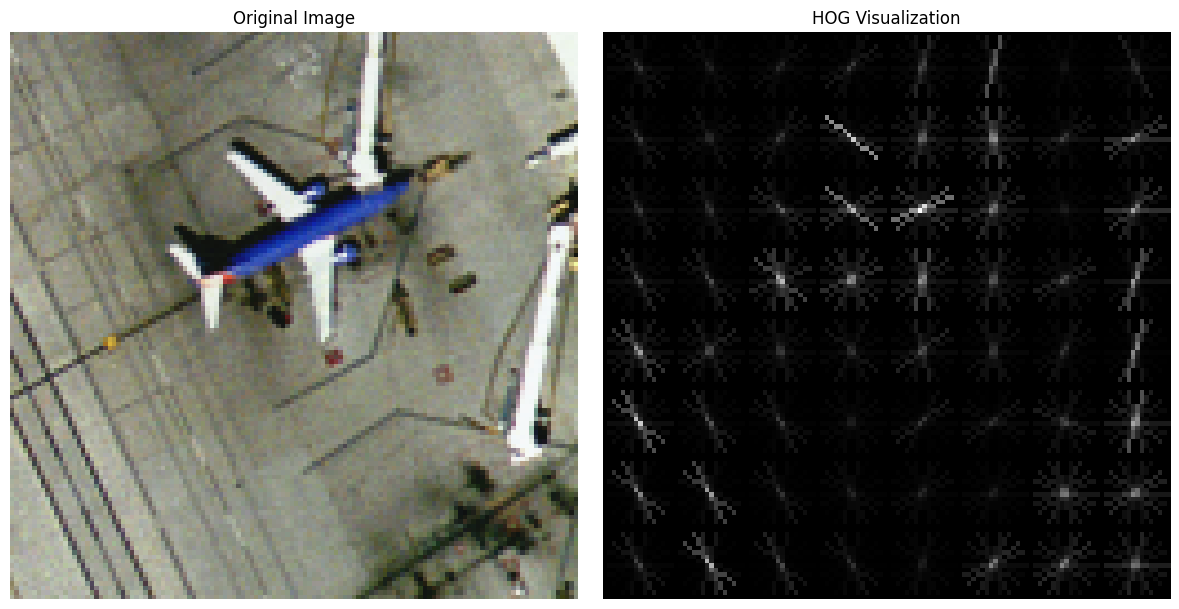

In [6]:
for i in range(5):
    img = cv2.imread(os.path.join(dataset_dir, "airplane", os.listdir(os.path.join(dataset_dir, "airplane"))[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    _, hog_img = detector.compute_hog(img, visualize=True)
    plot_hog_comparison(img, hog_img)


In [7]:
coefficients = detector.classifier.coef_[0]
print("Top 10 strongest features (indices):", np.argsort(np.abs(coefficients))[-10:])


Top 10 strongest features (indices): [ 810  334  306  558  360 1222  792  333 1542 1569]


# On building data, which gives poor result

Loading training data from UC Merced dataset...
Training SVM classifier on real HOG features...
Training Accuracy: 100.00%
Testing Accuracy: 87.50%


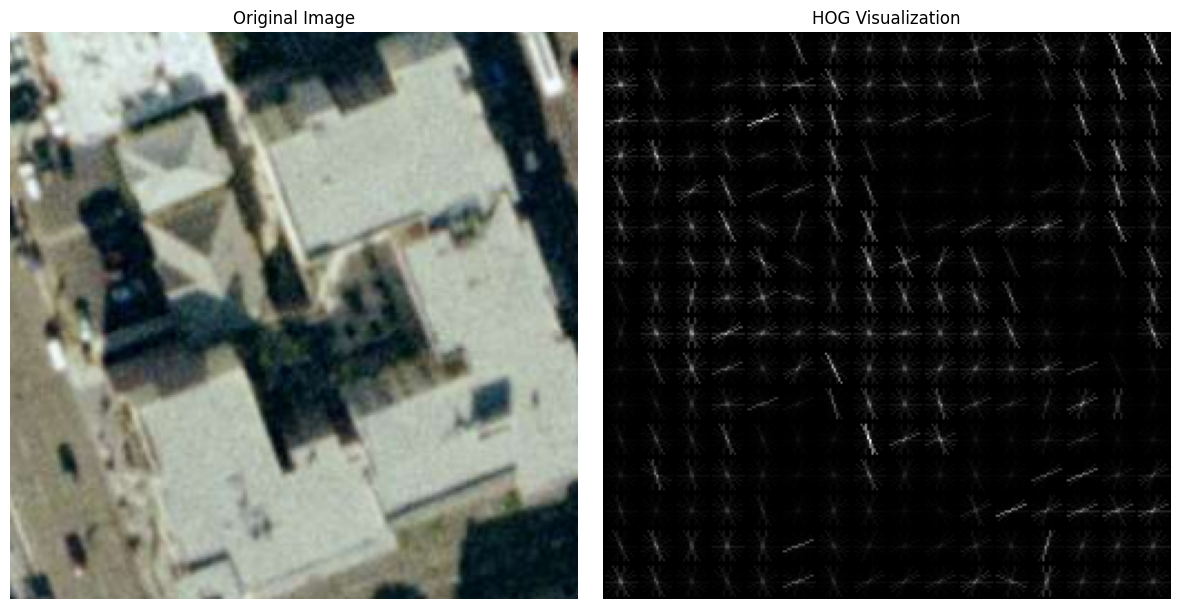

Running sliding window detection...
Raw detections: 10
Final detections after NMS: 3


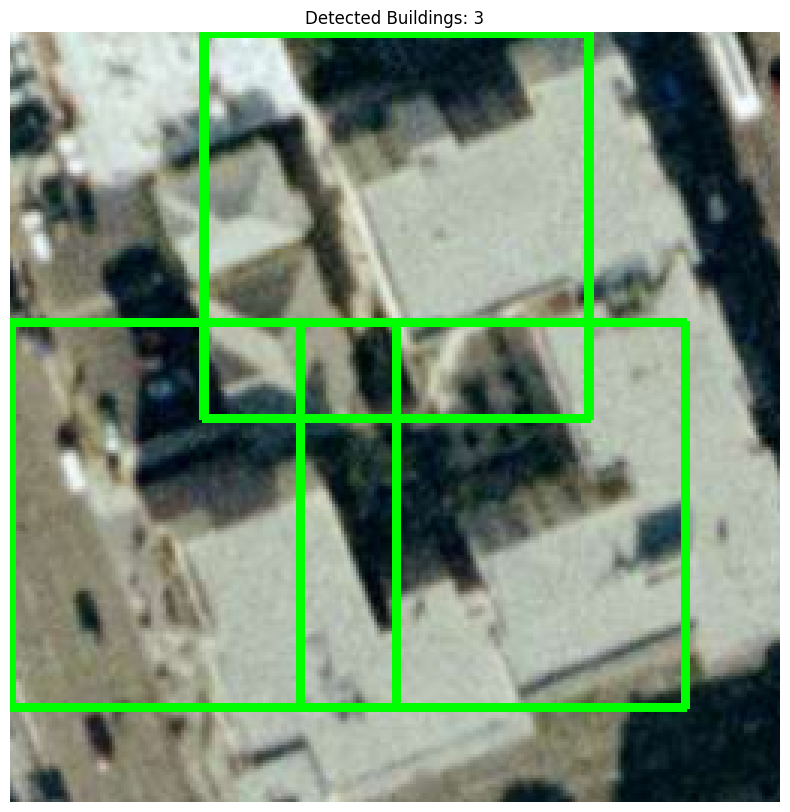

In [6]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from imutils.object_detection import non_max_suppression

class SatelliteHOGDetector:
    def __init__(self, cell_size=16, bin_size=9, block_size=2):
        self.cell_size = cell_size
        self.bin_size = bin_size
        self.block_size = block_size
        self.classifier = None

    def compute_hog(self, img, visualize=False):
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        if visualize:
            features, hog_image = hog(
                img,
                orientations=self.bin_size,
                pixels_per_cell=(self.cell_size, self.cell_size),
                cells_per_block=(self.block_size, self.block_size),
                block_norm='L2-Hys',
                visualize=True,
                transform_sqrt=True,
                feature_vector=True
            )
            hog_image = exposure.rescale_intensity(hog_image, in_range=(0, 10))
            return features, hog_image
        else:
            features = hog(
                img,
                orientations=self.bin_size,
                pixels_per_cell=(self.cell_size, self.cell_size),
                cells_per_block=(self.block_size, self.block_size),
                block_norm='L2-Hys',
                visualize=False,
                transform_sqrt=True,
                feature_vector=True
            )
            return features

    def train(self, X, y):
        self.classifier = SVC(kernel='linear', probability=True)
        self.classifier.fit(X, y)

    def detect_objects(self, img, window_size=(128, 128), stride=32, threshold=0.7):
        if self.classifier is None:
            raise ValueError("Classifier not trained!")

        detections = []
        img_height, img_width = img.shape[:2]

        for y in range(0, img_height - window_size[1], stride):
            for x in range(0, img_width - window_size[0], stride):
                window = img[y:y+window_size[1], x:x+window_size[0]]
                if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
                    continue
                features = self.compute_hog(window)
                proba = self.classifier.predict_proba([features])[0]

                if np.max(proba) > threshold:
                    detections.append((x, y, x+window_size[0], y+window_size[1], np.max(proba)))

        return detections
def load_ucmerced_data(dataset_dir, target_class="buildings", background_class="golfcourse", size=(128, 128), max_per_class=100):
    X = []
    y = []

    for class_name, label in [(target_class, 1), (background_class, 0)]:
        class_dir = os.path.join(dataset_dir, class_name)
        count = 0
        for file in os.listdir(class_dir):
            if file.endswith(".tif") or file.endswith(".jpg"):
                img = cv2.imread(os.path.join(class_dir, file))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, size)
                hog_feat = SatelliteHOGDetector().compute_hog(img)
                X.append(hog_feat)
                y.append(label)
                count += 1
                if count >= max_per_class:
                    break
    return np.array(X), np.array(y)
def plot_hog_comparison(original_img, hog_image):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(original_img, cmap='gray')
    ax1.set_title('Original Image')
    ax1.axis('off')
    ax2.imshow(hog_image, cmap='gray')
    ax2.set_title('HOG Visualization')
    ax2.axis('off')
    plt.tight_layout()
    plt.show()


def main():
    # 1. Load real training data
    dataset_dir = "/kaggle/input/uc-merced-land-use-dataset/UCMerced_LandUse/Images"
    print("Loading training data from UC Merced dataset...")
    X, y = load_ucmerced_data(dataset_dir)

    # 2. Train the classifier
    print("Training SVM classifier on real HOG features...")
    detector = SatelliteHOGDetector()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    detector.train(X_train, y_train)
    print(f"Training Accuracy: {detector.classifier.score(X_train, y_train)*100:.2f}%")
    print(f"Testing Accuracy: {detector.classifier.score(X_test, y_test)*100:.2f}%")

    # 3. Load test image and detect
    test_img_path = "/kaggle/input/uc-merced-land-use-dataset/UCMerced_LandUse/Images/buildings/buildings04.tif"  # Replace with a test image
    img = cv2.imread(test_img_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at {test_img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Optional: visualize HOG
    features, hog_img = detector.compute_hog(img, visualize=True)
    plot_hog_comparison(img, hog_img)

    print("Running sliding window detection...")
    detections = detector.detect_objects(img, window_size=(128, 128), stride=32, threshold=0.7)
    print(f"Raw detections: {len(detections)}")

    if detections:
        boxes = np.array([[x1, y1, x2, y2] for (x1, y1, x2, y2, _) in detections])
        scores = np.array([score for (_, _, _, _, score) in detections])
        pick = non_max_suppression(boxes, scores, overlapThresh=0.3)
        print(f"Final detections after NMS: {len(pick)}")
    else:
        pick = []

    # 4. Visualize results
    result_img = img.copy()
    for (x1, y1, x2, y2) in pick:
        cv2.rectangle(result_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(result_img)
    plt.title(f"Detected Buildings: {len(pick)}")
    plt.axis('off')
    plt.show()


if __name__ == "__main__":
    main()
